<center>
<h1> SOLUCIÓN TAREA 11</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

En primer lugar se cargan las librerias y funciones necesarias, para obtener y evaluar las segmentaciones con distintos métodos.

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

from scipy import ndimage as ndi

from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
from skimage.filters import (sobel,
                             threshold_multiotsu)
from skimage.measure import label
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed,
                                  mark_boundaries)

In [2]:
def pyramid(base, level):
    pyr=[]
    x=base.shape[0]
    y=base.shape[1]
    pyr.append(base)

    for i in range(level):
        if pyr[i].shape[1]<2 or pyr[i].shape[0]<2:
            break
        pyr.append(cv.pyrDown(pyr[i], dstsize=(pyr[i].shape[1]//2, pyr[i].shape[0]//2)))
    return pyr

def parents(x,y, parent):
    center=np.floor(np.array([np.floor(x/2)+x%2-0.5, np.floor(y/2)+y%2-0.5]))
    shape=parent.shape
    coor=[]
    color=[]
    
    for i in range(4):
        for j in range(4):
            point=center+np.array([i,j])
            if((point>=0).all()):
                if(point[0]<shape[0] and point[1]<shape[1]):
                    coor.append(point)
                    color.append(parent[int(point[0]), int(point[1])])
    return color, coor

def relations(child, parent):
    Csize=child.shape
    rel=np.zeros((Csize[0],Csize[1],2))
    for i in range(Csize[0]):
        for j in range(Csize[1]):
            parColor, parCoor = parents(i, j, parent)
            currPx = int(child[i,j])
            diff = [np.abs(x-currPx) for x in parColor]
            nearArg = np.argmin(diff)
            rel[i,j] = parCoor[nearArg]
    return rel

def regions(parent, relations, firstParent):
    x=relations.shape[0]
    y=relations.shape[1]
    segImg=np.zeros((x,y))
    for i, x in enumerate(relations):
        for j, coor in enumerate(x):
            segImg[i,j]=parent[int(coor[0]), int(coor[1])]
    return segImg
def pyrSegmentation(image, level):
    pyr=pyramid(image, level)
    rel=[]
    for i in range(len(pyr)-1):
        rel.append(relations(pyr[i], pyr[i+1]))
    first=True
    seg=pyr[len(pyr)-1]
    for i in reversed(range(len(pyr))):
        if i==0:
            break
        seg=regions(seg, rel[i-1], first)
        first=False
    return seg
def Otsu_Multinivel(img,niveles=3):
    # Aplicando el umbral multi-Otsu para n niveles
    umbrales = threshold_multiotsu(img,classes = niveles)
    # Utilizando los valores del umbral, generamos n regiones.
    regiones = np.digitize(img, bins=umbrales)
    return umbrales,regiones

Se usa una imagen de prueba y su respectivo borde, tomado de: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/gray/42049.html

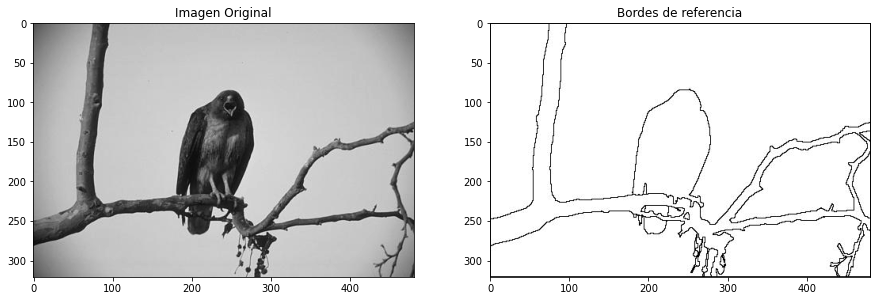

In [3]:
img=cv.imread('img/falcon.jpg',0)
borderRef=cv.imread('img/border.jpg',0)

plt.figure(1, figsize=[15,30])
plt.subplot(1,2,1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.title('Bordes de referencia')
plt.imshow(borderRef, cmap='gray')

A continuación se se realizan distintas segentaciones y se obtienen los bordes de las imagenes segmentadas para así ser comparadas con los bordes de referencia.

<h4>Segmentación basada en regiones</h4>
Se usa el algoritmo de tareas anteriores para segmentar la imagen y cuando hay regiones uniformes se obtienen sus bordes usando el Laplaciano.

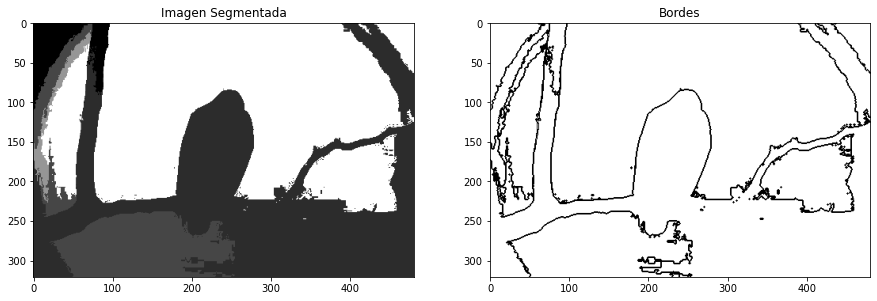

In [4]:
seg=pyrSegmentation(img, 7)
lap=np.absolute(cv.Laplacian(seg, cv.CV_64F))
trh, lapBin=cv.threshold(lap, 1, 255, cv.THRESH_BINARY_INV)
pyraBorders=np.uint8(lapBin)

plt.figure(1, figsize=[15,30])
plt.subplot(1,2,1)
plt.title('Imagen Segmentada')
plt.imshow(np.uint8(seg), cmap='gray')
plt.subplot(1,2,2)
plt.title('Bordes')
plt.imshow(lapBin, cmap='gray')

<h4>Segmentación basada en bordes</h4>
Luego se obtienen los bordes usando el algoritmo Canny.

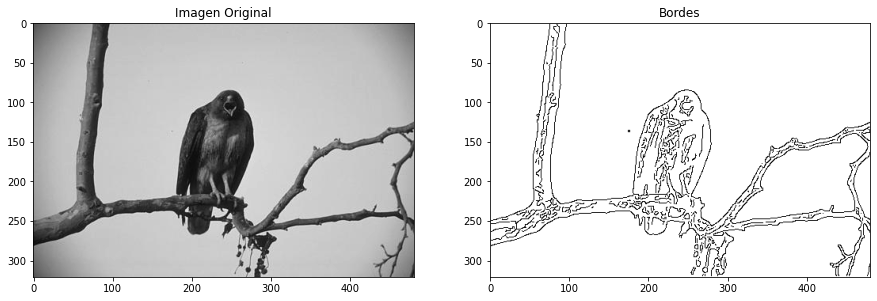

In [5]:
cannyBorders=canny(img)
cannyBorders=np.uint8(cannyBorders*255)
trh, cannyBorders=cv.threshold(cannyBorders, 200, 255, cv.THRESH_BINARY_INV)


plt.figure(1, figsize=[15,30])
plt.subplot(1,2,1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.title('Bordes')
plt.imshow(cannyBorders, cmap='gray')

<h4>Segmentación basada en umbrales</h4>
En este caso se usa el algoritmo Otsu multinivel con tres niveles de tal manera que sea comparable a la referencia, nuevamente se extraen los bordes de las regiones umbralizadas.

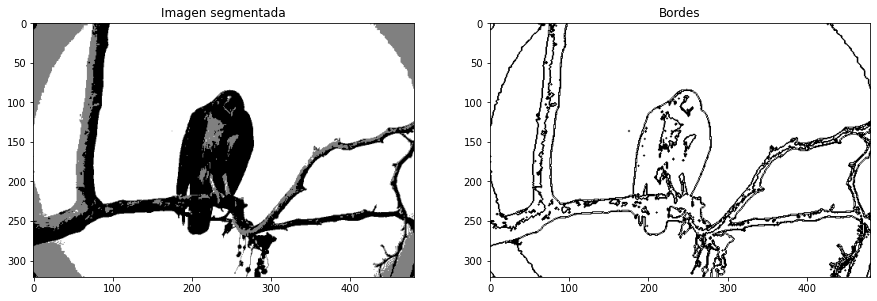

In [6]:
thr, otsu=Otsu_Multinivel(img,niveles=3)
otsu=np.uint8(otsu)
otsuLap=np.absolute(cv.Laplacian(otsu, cv.CV_64F))
trh, otsuBorders=cv.threshold(otsuLap, 0, 255, cv.THRESH_BINARY_INV)
otsuBorders=np.uint8(otsuBorders)

plt.figure(1, figsize=[15,30])
plt.subplot(1,2,1)
plt.title('Imagen segmentada')
plt.imshow(otsu, cmap='gray')
plt.subplot(1,2,2)
plt.title('Bordes')
plt.imshow(otsuBorders, cmap='gray')

Se muestran los bordes obtenidos con cada técnica sobre la imagen original, en este punto cabe resaltar que algunas técnicas llegan a econtrar bordes debido al cambio en el tono del fondo, esto sería un falso positivo, por otro lado con Otsu y Canny se encuentran muchos bordes debidos a la textura de los objetos.

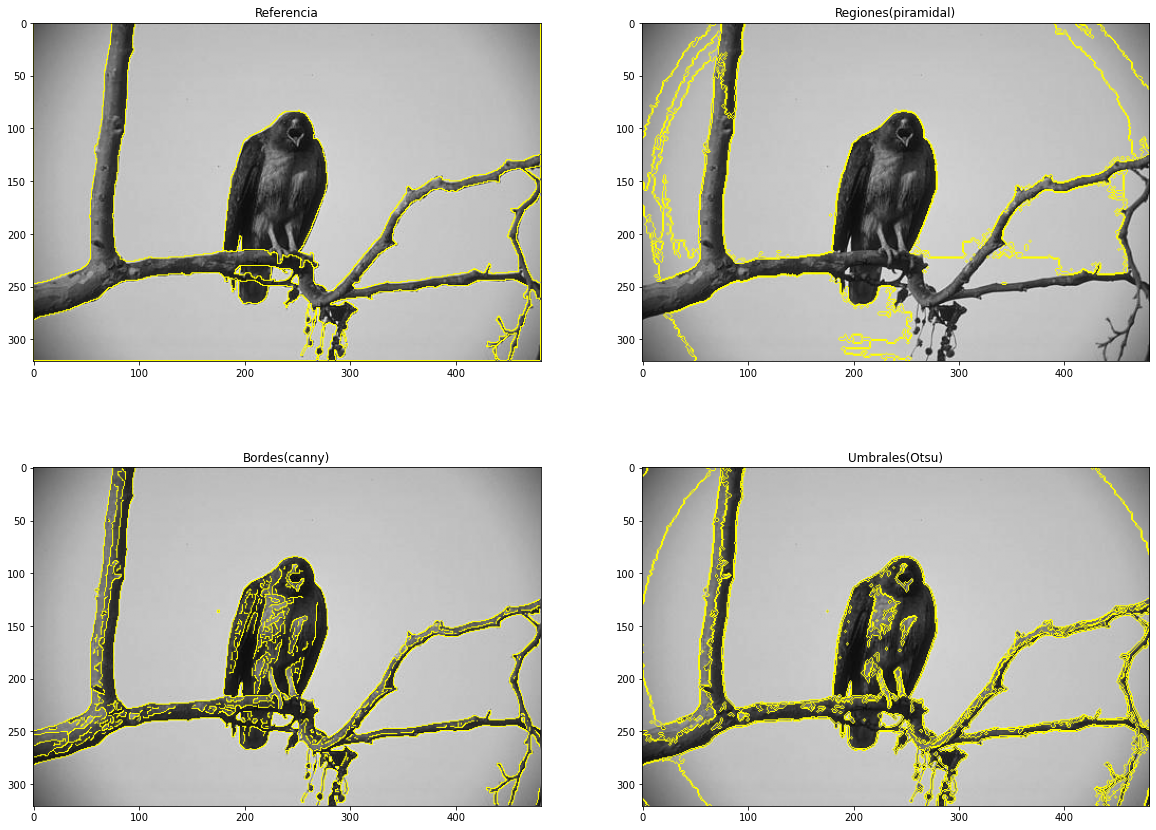

In [7]:
names=['Referencia' ,'Regiones(piramidal)', 'Bordes(canny)', 'Umbrales(Otsu)']
short_names=['Ref' ,'Piramidal', 'Canny', 'Otsu']
results=[borderRef ,pyraBorders, cannyBorders, otsuBorders]
plt.figure(4, figsize=[20,15])
for n, r in enumerate(results):
    plt.subplot(2,int(len(results)/2),n+1)
    plt.title(names[n])
    if(n==0):
        trh, ll=cv.threshold(r, 125, 255, cv.THRESH_BINARY)
        rr=np.uint8(ll)
        plt.imshow(mark_boundaries(img, rr), cmap='gray')
    else:
        plt.imshow(mark_boundaries(img, r), cmap='gray')

Finalmente se calculan metricas para comparar los métodos, se usa la matriz de confusión para encontrar la precision, la sensibilidad y el error, también se mide la variación de información para obtener una idea de la sobresegmentación y subsegmentación.


## Method: Referencia
Adapted Rand error: 0.0
Adapted Rand precision: 1.0
Adapted Rand recall: 1.0
Over-segmentation: 1.417610784431079e-16
Under-segmentation: 1.417610784431079e-16

## Method: Regiones(piramidal)
Adapted Rand error: 0.1342390320647986
Adapted Rand precision: 0.9191453639514797
Adapted Rand recall: 0.8182373565557188
Over-segmentation: 0.29468045685366445
Under-segmentation: 1.0920789428029498

## Method: Bordes(canny)
Adapted Rand error: 0.12541787890502265
Adapted Rand precision: 0.9367406635117111
Adapted Rand recall: 0.8201594630846821
Over-segmentation: 0.25612406041504115
Under-segmentation: 1.0857291162632445

## Method: Umbrales(Otsu)
Adapted Rand error: 0.12966239252465828
Adapted Rand precision: 0.9017315229236212
Adapted Rand recall: 0.8410561152590198
Over-segmentation: 0.36113428008745946
Under-segmentation: 1.0502220992527498


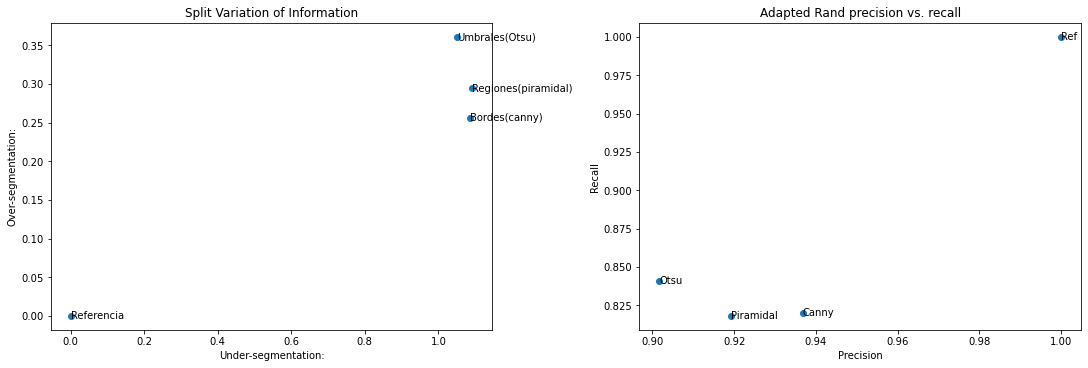

In [8]:
precision_list = []
recall_list = []
split_list = []
merge_list = []
for name, im_test in zip(names, results):
    error, precision, recall = adapted_rand_error(borderRef, im_test)
    splits, merges = variation_of_information(borderRef, im_test)
    split_list.append(splits)
    merge_list.append(merges)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f"\n## Method: {name}")
    print(f"Adapted Rand error: {error}")
    print(f"Adapted Rand precision: {precision}")
    print(f"Adapted Rand recall: {recall}")
    print(f"Over-segmentation: {splits}")
    print(f"Under-segmentation: {merges}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merge_list, split_list)
for i, txt in enumerate(names):
    ax[0].annotate(txt, (merge_list[i], split_list[i]),
                   verticalalignment='center')
ax[0].set_xlabel('Under-segmentation:')
ax[0].set_ylabel('Over-segmentation:')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision_list, recall_list)
for i, txt in enumerate(short_names):
    ax[1].annotate(txt, (precision_list[i], recall_list[i]),
                   verticalalignment='center')
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Rand precision vs. recall')

plt.show()

En conclusión el método con menos error es el Canny, lo cual era de esperarse ya que es un método orientado a extraer bordes. Todos los métodos tienen un indice de presición y sensibilidad muy cercano y superior al 82%, lo cual es aceptable.
En cuanto a sobresegmentación todos tiene un comportamiento similar pero en cuanto a subsegmentación se encuentra que la segmentación basada en umbrales tiene el peor rendimiento, esto quiere decir que tiende a detectar mas bordes de los que debería.